In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.constants as const
from scipy.interpolate import interp2d

# Problem 6

In [2]:
mu1 = 0.043 # cm^-1
mu2 = 0.061 # cm^-1
E1 = 2.75 # MeV
E2 = 1.37 # MeV

In [3]:
def exposure(energy, distance=6, activity=144):
    """Unshielded gamma exposure
    
    Unshielded exposure from gamma with energy (MeV)
    at distance (meters) from activity (Ci)
    
    Paramters
    ---------
    energy : float
        The energy of the gamma, in MeV
    distance : float
        Distance from the source, in m
    activity : float
        Activity of the source, in Ci
    
    Returns
    -------
    float
        exposure in R/hr
    """
    return 0.5 * activity * energy / distance ** 2

In [4]:
def shielding(dr_shielded, dr_unshielded, mass_transfer_coefficient, buildup_factor=1.0):
    """The shield thickness to reduce exposure from dr_unshielded to dr_shielded
    
    Parameters
    ----------
    dr_shielded : float
        The desired exposure rate at the other side of the shield
    dr_unshielded : float
        The exposure rate if there was no shield
    mass_transfer_coefficient : float
        The mass transfer coefficient in cm^-1
    buildup_factor
        
    Returns
    -------
    float
        The thickness of shielding required, in cm
    """
    return -(1 / mass_transfer_coefficient) * np.log(dr_shielded / dr_unshielded)

In [5]:
def buildupfactor(energy, mux, convergence=1e-5, max_iterations=1e5):
    error = 100.
    iteration_count = 0
    bf = 1.
    while error > convergence and iteration_count < max_iterations:
        iteration_count += 1
        
        bf_old = bf
        bf = bf_interp(mux + np.log(bf), energy)
        
        error = abs(bf - bf_old) / bf
    return bf

In [6]:
mux = np.array([0.5, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 25, 30, 35, 40])

In [7]:
energies = np.array([3, 2, 1.5, 1])

In [8]:
bf = np.array([
        [1.34, 1.71, 2.47, 3.24, 4.01, 4.81, 5.62, 6.45, 7.28, 8.98, 13.4, 17.8, 22.4, 27.1, 31.8, 36.5],
        [1.38, 1.83, 2.82, 3.87, 4.99, 6.16, 7.38, 8.66, 9.97, 12.7, 20.1,   28, 36.4, 45.2, 54.3,   63],
        [1.42, 1.93, 3.11, 4.44,  5.9, 7.47, 9.14, 10.9, 12.8, 16.8, 27.9, 40.4, 54.1, 68.8, 84.4,  101],
        [1.47, 2.08, 3.62,  5.5, 7.66, 10.1, 12.8, 15.7, 18.9,   26, 47.4, 73.5,  104,  138,  175,  214]
    ])

In [9]:
bf_interp = interp2d(mux, energies, bf)

In [10]:
bf_interp(5.62+np.log(7.62084246), 2.75)

array([ 7.62084258])

In [11]:
5.62+np.log(7.62084246)

7.6508869226424707

In [12]:
7.62084258*5500*np.exp(-7.6508869226424707)

19.935526413222252

In [69]:
mux2 = 7.6508869226424707 * 0.061 / 0.043
mux2

10.85358377398118

In [72]:
bf_interp(mux2, 1.37)

array([ 21.54413545])

In [15]:
mux2+np.log(31.00743319)

14.2878107300462

In [16]:
31.00749125*2740*np.exp(-14.2878107300462)

0.052978521507327576

In [17]:
19.935526413222252+0.052978521507327576

19.98850493472958

In [18]:
7.6508869226424707 / 0.043

177.9276028521505

In [19]:
buildupfactor(2.75, 5.62)

array([ 7.62083418])

In [20]:
buildupfactor(1.37, (5.62 + np.log(7.62083418)) * 0.061 / 0.043)

array([ 31.00748659])

In [70]:
exposure(activity=144, distance=6, energy=1.37)

2.74

# Problem 7

In [21]:
wbde = pd.DataFrame({
        'Exposure (mGy)': [2., 5, 5, 40, 2000],
        'Radiation': ['alpha', 'thermal neutron', 'gamma', 'beta', 'beta'],
        'Target': ['lung', 'whole body', 'whole body', 'thyroid', 'skin']
    })

# https://www.euronuclear.org/info/encyclopedia/r/radiation-weight-factor.htm
q_factor = {
    'alpha': 20,
    'gamma': 1, 
    'beta': 1,
    'thermal neutron': 2.5 + 18.2 * np.exp(-(np.log(0.025e-6))**2 / 6)
}

# http://www.icrp.org/docs/David%20Brenner%20Effective%20Dose%20a%20Flawed%20Concept.pdf
tissue_weighting_factor = {
    'lung': 0.12,
    'whole body': 1., 
    'thyroid': 0.04,
    'skin': 0.01
}

In [22]:
print(tissue_weighting_factor)
print(q_factor)

{'thyroid': 0.04, 'whole body': 1.0, 'lung': 0.12, 'skin': 0.01}
{'alpha': 20, 'beta': 1, 'gamma': 1, 'thermal neutron': 2.5}


In [68]:
wbde['Dose'] = wbde.apply(lambda x: q_factor.get(x['Radiation']) * x['Exposure (mGy)'], axis=1)
wbde['Whole-Body Equivalent'] = wbde.apply(lambda x: tissue_weighting_factor.get(x['Target']) * x['Dose'], axis=1)
wbde.to_latex()

u'\\begin{tabular}{lrllrr}\n\\toprule\n{} &  Exposure (mGy) &        Radiation &      Target &    Dose &  Whole-Body Equivalent \\\\\n\\midrule\n0 &               2 &            alpha &        lung &    40.0 &                    4.8 \\\\\n1 &               5 &  thermal neutron &  whole body &    12.5 &                   12.5 \\\\\n2 &               5 &            gamma &  whole body &     5.0 &                    5.0 \\\\\n3 &              40 &             beta &     thyroid &    40.0 &                    1.6 \\\\\n4 &            2000 &             beta &        skin &  2000.0 &                   20.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [24]:
np.sum(wbde['Whole-Body Equivalent'])

43.900000000000006

## Which, if any, exposure limits were violated

Compare to [NCRP/FDA Regulations](http://www.ceessentials.net/article6.html#section5_5)
- Total exposure 43.9 mSv < 50 mSv (annual)
- Dose equivalent to skin 20.0 mSv < 500 mSv

# Problem 8

In [78]:
becquerels_per_curie = 3.7e10
joules_per_eV = 1.6e-19
weight = 74 # kg
activity = 1.0e-3 # Ci
c_max = activity * becquerels_per_curie / weight # Bq / kg
delta = 10e3 * joules_per_eV # J
decay_physical = np.log(2.) / (2 * 365.241 * 24 * 60 * 60) # s^-1
decay_biological = np.log(2.) / (1 * 365.241 * 24 * 60 * 60) # s^-1
print(c_max)
print(delta)
print(decay_biological)
print(decay_physical)
print(decay_physical + decay_biological)

500000.0
1.6e-15
2.19650499589e-08
1.09825249794e-08
3.29475749383e-08


In [79]:
def dose(time):
    # convert time from years to seconds
    time = time * 365.241 * 24 * 60 * 60
    d1 = c_max * delta / (decay_biological + decay_physical)
    print d1
    d2 = (1 - np.exp(-(decay_physical + decay_biological) * time))
    return d1 * d2

In [64]:
dose(1)

0.015696368806906228

In [80]:
dose(5)

0.0242809979641


0.024146863133522135

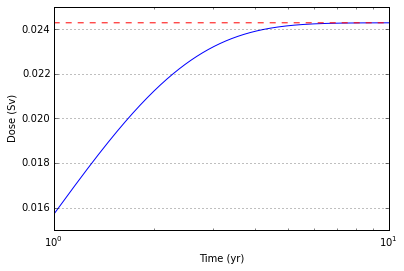

In [67]:
d = np.linspace(1, 10, 1e5)
plt.plot(d, dose(d))
plt.xscale('log')
plt.plot(d, [c_max * delta / (decay_biological + decay_physical) for i in d], 'r--')
plt.ylabel(r'Dose (Sv)')
plt.xlabel(r'Time (yr)')
plt.grid()
plt.show()

In [65]:
c_max * delta / (decay_biological + decay_physical)

0.024280997964103341